## Bootstrapping sex linked marker sets

In [15]:
%matplotlib inline
import MISC_RAD_tools as MISC
import SLMF_lightweight as SLMF_L

In this notebook I will first compile all of the final stacks outputs for each species dataset (or subset) and then, for each one, I will randomise the male and female assignments accross the samples. For 100 random male female assignments I will then run the sex linked marker finding analyses, using exactly the parameters used to identify the final set of sex linked markers in the paper. The only difference is the male and female assignments. 

This randomisation will give an idea of what the false positive rate in the dataset is. For example, a skew towards more males or females in the dataset may make false positives of one type or another more likely. Also, if there are several populations in the data and males and females are not distributed evenly among them then population structure could look like sex linkage. However, randomising male and female assignments across all samples will allow us to account for this. 

Due to the prohibitively long amount of time that it would take, I will not do 1000 randomisations for each species, although this is what I would prefer. Instead I will just do 100, this should still give a reasonably good estimate for the false positive rate. 

With regards to how these randomisations will be used to judge the validity of the dataset, I will look for sample sets where the number of sex-linked markers found using the correct male/female assignments is above the 95th percentile of the distribution of sex-linked markers found in the randomisations. 

In collaboration with the genome mapping, this should help validate the sex-linked markers sets found.



#### First, make a list of all of the parameter disctionaries, which contain paths and parameters used for finding sex linked markers


In [1]:
Parameter_dictionaries = []

### Hyla orientalis

In [2]:
Parameter_dict_Hori = {}
Parameter_dict_Hori["Name"] = "Hori"

##### Data ########################

Parameter_dict_Hori['Catalog'] =  "/home/djeffrie/Data/RADseq/Hori/Stacks_new/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict_Hori['VCF'] =  "/home/djeffrie/Data/RADseq/Hori/Stacks_new/Populations_Clade_A2//batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict_Hori['Pop_map'] = "/home/djeffrie/Data/RADseq/Hori/Stacks_new/Populations_Clade_A2/Sex_ID_info_Clade_A2.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict_Hori['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict_Hori['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict_Hori['coverage_threshold1'] = 7 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict_Hori['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict_Hori['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict_Hori['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict_Hori['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict_Hori['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict_Hori['coverage_threshold2'] = 7 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict_Hori['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict_Hori['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.

Parameter_dictionaries.append(Parameter_dict_Hori)


In [ ]:
/home/djeffrie/Data/RADseq/Hori/Stacks_new/Randomisations

In [12]:
print "There are %s species for which sex linked markers were found that will be randomised" % len(Parameter_dictionaries)

There are 1 species for which sex linked markers were found that will be randomised


The program will work as follows:

For every species, it will
    1. make a new directory
    2. Move the sex information file and vcf file into that directory
    3. Make the randomised sex information files and renamed vcf files
    4. Run the randomisation prgroam for that species and collect results
    5. Write results to an output file
    6. Tidy up loose files
    7. Plot the results



In [13]:
## Define a program to help parallelise the analyses


def Super_SLM_finder_parallel(popmap, Parameter_dict):
    import os
    
    Parameter_dict['Pop_map'] = popmap
    Parameter_dict['VCF'] = "%s.vcf" % popmap.rpartition(".")[0]
    results_dict = {}
    results_dict["XYset"], results_dict["ZWset"], results_dict["Detailed"] = SLMF_L.Super_SLM_finder(Parameter_dict, "111", verbose = False, write_files=False, plot=False)
    
    os.remove(Parameter_dict['VCF']) ## remove VCFs as they are used
    os.remove("%s.altered" % Parameter_dict['VCF'])
    os.remove("%s.all_frequencies.tsv" % Parameter_dict['VCF'])
    

    return results_dict
    
    

In [16]:
from joblib import Parallel, delayed
import multiprocessing
import os
import shutil
from random import shuffle

results_dict = {}

for dataset in Parameter_dictionaries:
    print "processing dataset in", dataset["VCF"]
    # 1. Make a new directory next in the VCF path. 
    Randomisation_dir = "%s/Randomisations" % dataset["VCF"].rpartition("/")[0]
    if not os.path.exists(Randomisation_dir):
        os.makedirs(Randomisation_dir)
    
    # 2. Copy sex info and VCF into that folder
    
    shutil.copyfile(dataset["Pop_map"], "%s/Sex_ID_info.txt" % Randomisation_dir)  ## sex info
    shutil.copyfile(dataset["VCF"], "%s/batch_1.vcf" % Randomisation_dir)  ## sex info
    
    orig_vcf = "%s/batch_1.vcf" % Randomisation_dir
    
    print "\nRandomisations happening in %s" % Randomisation_dir
    
    ## 3. Make the randomised sex info files

    orig_popmap_path = "%s/Sex_ID_info.txt" % Randomisation_dir
    orig_popmap = open(orig_popmap_path, 'r').readlines()

    sexes = []
    samples = []
    IDs = []
    randomisations = []

    for line in orig_popmap:
        sexes.append(line.strip().split()[1])
        samples.append(line.strip().split()[0])
        IDs.append(line.strip().split()[2])

    popmaps = []
    for i in range(100):
        popmap_path = "%s/rand_popmap_%s.txt" % (Randomisation_dir, i)
        popmaps.append(popmap_path)
        rand_popmap = open(popmap_path, 'w')
        shuffle(sexes)
        randomisations.append(sexes)
        
        for i in range(len(samples)):
            rand_popmap.write("%s\t%s\t%s\n" % (samples[i], sexes[i], IDs[i]))

        rand_popmap.close()
    
    print "\nRandom sex info files made"
    
    ## make new VCFs for parallelised analyses
    
    for i in popmaps:
        new_vcf = "%s.vcf" % i.rpartition(".")[0]
        shutil.copyfile(orig_vcf, new_vcf)
        
    ## 4. Run the randomisations
    
    print "\nRunning randomisations\n"
    
    results_dict[dataset["Name"]] = Parallel(n_jobs=4, verbose = 1)(delayed(Super_SLM_finder_parallel)(i, dataset) for i in popmaps)
    
    ## 5. Output the results for each species after the species is complete (i.e. checkpoints)
    
    outfile = open("%s/Randomisations_%s.txt" % (Randomisation_dir, dataset["Name"]), 'w')
    
    for Randomisation in results_dict[dataset["Name"]]:

        XYfreq = len(Randomisation["Detailed"]["XY"]["freq"])
        XYhet = len(Randomisation["Detailed"]["XY"]["het"])
        Ytags = len(Randomisation["Detailed"]["XY"]["Ytags"])
    
        ZWfreq = len(Randomisation["Detailed"]["ZW"]["freq"])
        ZWhet = len(Randomisation["Detailed"]["ZW"]["het"])
        Wtags = len(Randomisation["Detailed"]["ZW"]["Wtags"])
                
        line = "%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % (dataset["Name"],XYfreq,XYhet,Ytags,ZWfreq,ZWhet,Wtags)
    
        outfile.write(line)
        
    outfile.close()
    
    print "Results outputted to %s/Randomisations_%s.txt" % (Randomisation_dir, dataset["Name"])
    
    
    

processing dataset in /home/djeffrie/Data/RADseq/Hori/Stacks_new/Populations_Clade_A2//batch_1.vcf

Randomisations happening in /home/djeffrie/Data/RADseq/Hori/Stacks_new/Populations_Clade_A2//Randomisations

Random sex info files made

Running randomisations



[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 20.3min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 46.8min finished


Results outputted to /home/djeffrie/Data/RADseq/Hori/Stacks_new/Populations_Clade_A2//Randomisations/Randomisations_Lchiri.txt
Final number of XY tags = 1
Final number of XY tags = 2
Final number of XY tags = 5
Final number of XY tags = 0
Final number of ZW tags = 1
Final number of ZW tags = 1
Final number of ZW tags = 1
Final number of ZW tags = 0
Final number of XY tags = 1Final number of XY tags = 0Final number of XY tags = 2Final number of XY tags = 0



Final number of ZW tags = 2
Final number of ZW tags = 1
Final number of ZW tags = 2
Final number of ZW tags = 2
Final number of XY tags = 0Final number of XY tags = 1Final number of XY tags = 1Final number of XY tags = 2



Final number of ZW tags = 1
Final number of ZW tags = 1
Final number of ZW tags = 3
Final number of ZW tags = 2
Final number of XY tags = 0Final number of XY tags = 1Final number of XY tags = 1Final number of XY tags = 1



Final number of ZW tags = 1
Final number of ZW tags = 2
Final number of ZW tags = 2
Final


Plotting Randomisations_Hori

XYfreq_sig 99
XYhet_sig 99
Ytags_sig 99
ZW_freqs_sig Non_sig
ZW_hets_sig Non_sig
Wtags_sig Non_sig
XYvsZW_freqs_sig 99
XYvsZW_hets_sig 99
XYvsZW_tagss_sig 99


/home/djeffrie/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


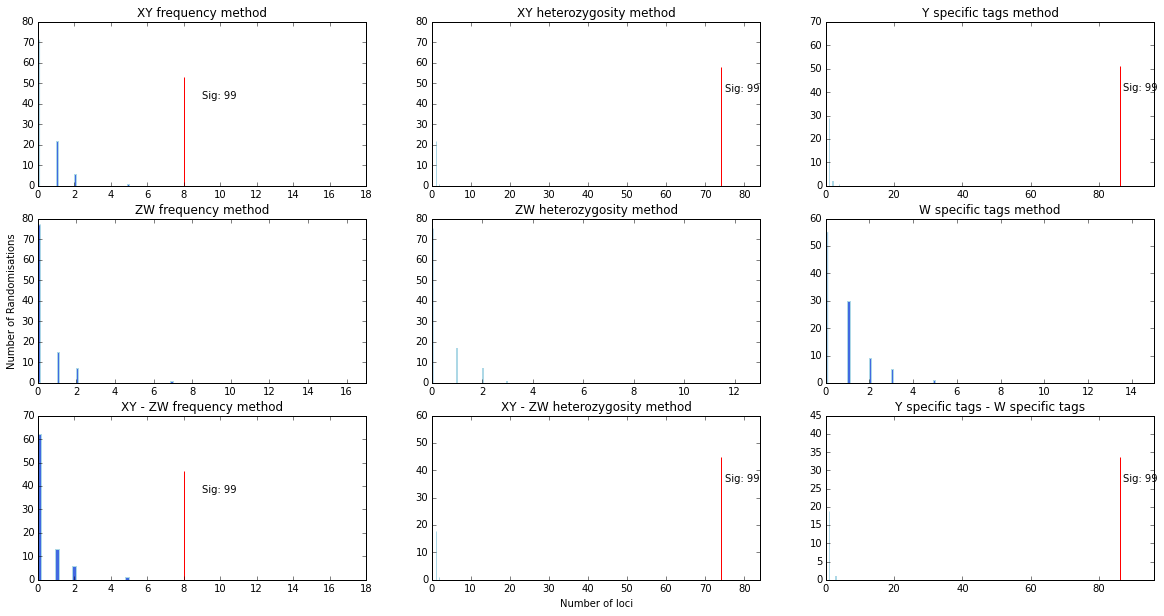

In [30]:
myrealdatapath = "/home/djeffrie/Data/RADseq/Hori/Stacks_new/Populations_Clade_A2/Randomisations/Real_data.txt"
myrandomisation_directory = "/home/djeffrie/Data/RADseq/Hori/Stacks_new/Populations_Clade_A2/Randomisations"

randomisation_plotter(myrandomisation_directory, myrealdatapath, plot=True, Outs_constant=2)

## So all went well, randomisations completed in less than 24 hours with 100 randomisations per dataset. 

### Now to plot

In [29]:
def removeOutliers(x, outlierConstant):
    """
    An outlier here is defined as a value more than 1.5* the IQ range
    but constants higher than 1.5 can be used to be more stringent
    
    """
    import numpy as np
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    resultList = []
    for y in a.tolist():
        if y > quartileSet[0] and y < quartileSet[1]:
            resultList.append(y)
    return resultList

In [26]:
def randomisation_plotter(Randomisation_directory, realdatapath, Outs_constant = 1.5, plot = True):
    
    import os
    from matplotlib import pyplot as plt
    import numpy as np
    
    randomisation_files = []
    
    for root, dirs, files in os.walk(Randomisation_directory):
        for fil in files:
            if fil.startswith("Randomisation") and fil.endswith("txt") and "sigs" not in fil:
                randomisation_files.append("%s/%s" % (root, fil))

    rando_sig_file = open("%s/Randomisation_sigs.txt" % Randomisation_directory, 'w')
            
    rando_sig_file.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % ("species", \
                                 "realXYfreq_sig", \
                                 "realXYhet_sig", \
                                 "Ytags_sig", \
                                 "ZW_freqs_sig", \
                                 "ZW_hets_sig", \
                                 "W_tagss_sig", \
                                 "XYvsZW_freqs_sig",\
                                 "XYvsZW_tagss_sig"))
    
    for randomisation_filepath in randomisation_files:
        
        print "\nPlotting %s\n" % randomisation_filepath.rpartition("/")[2].rpartition(".")[0]

        randomisations = open(randomisation_filepath, 'r').readlines()

        XYfreqs = []
        XYhets = []
        Ytags = []

        ZW_freqs = []
        ZW_hets = []
        W_tagss = []

        XYvsZW_freqs = []
        XYvsZW_hets = []
        XYvsZW_tagss = []

        ## Get randomisation data
        
        for line in randomisations:
            #print line.split()
            species = line.split()[0]
            XYfreq = line.split()[1]
            XYhet = line.split()[2]
            Y_tags = line.split()[3]

            ZW_freq = line.split()[4]
            ZW_het = line.split()[5]
            W_tags = line.split()[6]

            XYvsZW_freq = int(XYfreq) - int(ZW_freq)
            XYvsZW_het = int(XYhet) - int(ZW_het)
            XYvsZW_tags = int(Y_tags) - int(W_tags)

            XYfreqs.append(int(XYfreq))
            XYhets.append(int(XYhet))
            Ytags.append(int(Y_tags))
            ZW_freqs.append(int(ZW_freq))
            ZW_hets.append(int(ZW_het))
            W_tagss.append(int(W_tags))
            XYvsZW_freqs.append(int(XYvsZW_freq))
            XYvsZW_hets.append(int(XYvsZW_het))
            XYvsZW_tagss.append(int(XYvsZW_tags))
    

        ## Get the real data from the file
        realdata = open(realdatapath, 'r').readlines()

        for line in realdata:
            if species == line.split()[0]:
                realXYfreq = int(line.split()[1])
                realXYhet = int(line.split()[2])
                realYtags = int(line.split()[3])
                realZWfreq = int(line.split()[4])
                realZWhet = int(line.split()[5])
                realWtags = int(line.split()[6])
        

        realXYvsZWfreq = realXYfreq - realZWfreq
        realXYvsZWhet = realXYhet - realZWhet
        realYvsWtags = realYtags - realWtags

        
        ## Test to see if the real data is significantly higher than the randomisations
        
        ## First check that the IQR is greater than zero, otherwise there the downstream stats won't work
            ## if the IQR is greater than zero, remove any outliers in the datasets
        
        if not (np.percentile(XYfreqs, 75) - np.percentile(XYfreqs, 25)) * Outs_constant == 0:
            XYfreqs_no_outs = removeOutliers(XYfreqs, Outs_constant)
        else:
            XYfreqs_no_outs = XYfreqs
            
        if not (np.percentile(XYhets, 75) - np.percentile(XYhets, 25)) * Outs_constant == 0:
            XYhets_no_outs = removeOutliers(XYhets, Outs_constant)
        else:
            XYhets_no_outs = XYhets
            
        if not (np.percentile(Ytags, 75) - np.percentile(Ytags, 25)) * Outs_constant == 0:
            Ytags_no_outs = removeOutliers(Ytags, Outs_constant)
        else:
            Ytags_no_outs = Ytags
            
        if not (np.percentile(ZW_freqs, 75) - np.percentile(ZW_freqs, 25)) * Outs_constant == 0:
            ZW_freqs_no_outs = removeOutliers(ZW_freqs, Outs_constant)
        else:
            ZW_freqs_no_outs = ZW_freqs
            
        if not (np.percentile(ZW_hets, 75) - np.percentile(ZW_hets, 25)) * Outs_constant == 0:
            ZW_hets_no_outs = removeOutliers(ZW_hets, Outs_constant)
        else:
            ZW_hets_no_outs = ZW_hets
            
        if not (np.percentile(W_tagss, 75) - np.percentile(W_tagss, 25)) * Outs_constant == 0:
            W_tagss_no_outs = removeOutliers(W_tagss, Outs_constant)
        else:
            W_tagss_no_outs = W_tagss
        
        
        if not (np.percentile(XYvsZW_freqs, 75) - np.percentile(XYvsZW_freqs, 25)) * Outs_constant == 0:
            XYvsZW_freqs_no_outs = removeOutliers(XYvsZW_freqs, Outs_constant)
        else:
            XYvsZW_freqs_no_outs = XYvsZW_freqs
        
        if not (np.percentile(XYvsZW_hets, 75) - np.percentile(XYvsZW_hets, 25)) * Outs_constant == 0:
            XYvsZW_hets_no_outs = removeOutliers(XYvsZW_hets, Outs_constant)
        else:
            XYvsZW_hets_no_outs = XYvsZW_hets
            
        if not (np.percentile(XYvsZW_tagss, 75) - np.percentile(XYvsZW_tagss, 25)) * Outs_constant == 0:
            XYvsZW_tagss_no_outs = removeOutliers(XYvsZW_tagss, Outs_constant)
        else:
            XYvsZW_tagss_no_outs = XYvsZW_tagss

        ## set "Non-sig" as default
        
        realXYfreq_sig = "Non_sig"
        realXYhet_sig = "Non_sig"
        Ytags_sig = "Non_sig"
        ZW_freqs_sig = "Non_sig"
        ZW_hets_sig = "Non_sig"
        W_tagss_sig = "Non_sig"
        XYvsZW_freqs_sig = "Non_sig"
        XYvsZW_hets_sig = "Non_sig"
        XYvsZW_tagss_sig = "Non_sig"
        
        
        ## if the real value is higher than the 95th or 99th percentile, then record sig level
        
        if realXYfreq > np.round(np.percentile(XYfreqs_no_outs, 95),3):
            realXYfreq_sig = 95
        if realXYfreq > np.round(np.percentile(XYfreqs_no_outs, 99),3):
            realXYfreq_sig = 99

        if realXYhet > np.round(np.percentile(XYhets_no_outs, 95),3):
            realXYhet_sig = 95
        if realXYhet > np.round(np.percentile(XYhets_no_outs, 99),3):
            realXYhet_sig = 99
            
        if realYtags > np.round(np.percentile(Ytags_no_outs, 95),3):
            Ytags_sig = 95
        if realYtags > np.round(np.percentile(Ytags_no_outs, 99),3):
            Ytags_sig = 99
            
        if realZWfreq > np.round(np.percentile(ZW_freqs_no_outs, 95),3):
            ZW_freqs_sig = 95
        if realZWfreq > np.round(np.percentile(ZW_freqs_no_outs, 99),3):
            ZW_freqs_sig = 99
            
        if realZWhet > np.round(np.percentile(ZW_hets_no_outs, 95),3):
            ZW_hets_sig = 95
        if realZWhet > np.round(np.percentile(ZW_hets_no_outs, 99),3):
            ZW_hets_sig = 99
        
        if realWtags > np.round(np.percentile(W_tagss_no_outs, 95),3):
            W_tagss_sig = 95
        if realWtags > np.round(np.percentile(W_tagss_no_outs, 99),3):
            W_tagss_sig = 99    
        
        if realXYvsZWfreq > np.round(np.percentile(XYvsZW_freqs_no_outs, 95),3):
            XYvsZW_freqs_sig = 95
        if realXYvsZWfreq > np.round(np.percentile(XYvsZW_freqs_no_outs, 99),3):
            XYvsZW_freqs_sig = 99
            
        if realXYvsZWhet > np.round(np.percentile(XYvsZW_hets_no_outs, 95),3):
            XYvsZW_hets_sig = 95
        if realXYvsZWhet > np.round(np.percentile(XYvsZW_hets_no_outs, 99),3):
            XYvsZW_hets_sig = 99
        
        if realYvsWtags > np.round(np.percentile(XYvsZW_tagss_no_outs, 95),3):
            XYvsZW_tagss_sig = 95
        if realYvsWtags > np.round(np.percentile(XYvsZW_tagss_no_outs, 99),3):
            XYvsZW_tagss_sig = 99    

        print "XYfreq_sig", realXYfreq_sig
        print "XYhet_sig", realXYhet_sig
        print "Ytags_sig", Ytags_sig
        print "ZW_freqs_sig", ZW_freqs_sig
        print "ZW_hets_sig", ZW_hets_sig
        print "Wtags_sig", W_tagss_sig
        print "XYvsZW_freqs_sig", XYvsZW_freqs_sig
        print "XYvsZW_hets_sig", XYvsZW_hets_sig
        print "XYvsZW_tagss_sig", XYvsZW_tagss_sig
        
        
        rando_sig_file.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % (species, \
                                 realXYfreq_sig, \
                                 realXYhet_sig, \
                                 Ytags_sig, \
                                 ZW_freqs_sig, \
                                 ZW_hets_sig, \
                                 W_tagss_sig, \
                                 XYvsZW_freqs_sig,\
                                 XYvsZW_tagss_sig))
        
        if plot == True:

            fig = plt.figure(figsize = (20,10))

            fig.add_subplot(3,3,1)

            counts, bins, bars = plt.hist(XYfreqs, bins= 50, edgecolor = "lightblue", color = "royalblue")
            if max(XYfreqs) >= realXYfreq:
                plt.xlim((0,max(XYfreqs)+10))
            else:
                plt.xlim((0,realXYfreq+10))
            plt.vlines(realXYfreq, 0, max(counts)*0.75, color = "red")
            plt.title("XY frequency method")
            if realXYfreq_sig == 99 or realXYfreq_sig == 95:
                plt.text(realXYfreq+1, max(counts)*0.6, "Sig: %s" % realXYfreq_sig)


            fig.add_subplot(3,3,2)
            counts, bins, bars = plt.hist(XYhets, bins= 50, edgecolor = "lightblue", color = "royalblue")
            if max(XYhets) >= realXYhet:
                plt.xlim((0,max(XYhets)+10))
            else:
                plt.xlim((0,realXYhet+10))
            plt.vlines(realXYhet, 0, max(counts)*0.75, color = "red")
            plt.title("XY heterozygosity method")
            if realXYhet_sig == 99 or realXYhet_sig == 95:
                plt.text(realXYhet+1, max(counts)*0.6, "Sig: %s" % realXYhet_sig)

                
            fig.add_subplot(3,3,3)
            counts, bins, bars = plt.hist(Ytags, bins= 50, edgecolor = "lightblue", color = "royalblue")
            if max(Ytags) >= realYtags:
                plt.xlim((0,max(Ytags)+10))
            else:
                plt.xlim((0,realYtags+10))
            plt.vlines(realYtags, 0, max(counts)*0.75, color = "red")
            plt.title("Y specific tags method")
            if Ytags_sig == 99 or Ytags_sig == 95:
                plt.text(realYtags+1, max(counts)*0.6, "Sig: %s" % Ytags_sig)
                
                
            fig.add_subplot(3,3,4)
            counts, bins, bars = plt.hist(ZW_freqs, bins= 50, edgecolor = "lightblue", color = "royalblue")
            if max(ZW_freqs) >= realZWfreq:
                plt.xlim((0,max(ZW_freqs)+10))
            else:
                plt.xlim((0,realZWfreq+10))
            plt.vlines(realZWfreq, 0, max(counts)*0.75, color = "red")
            plt.title("ZW frequency method")
            plt.ylabel("Number of Randomisations")
            if ZW_freqs_sig == 99 or ZW_freqs_sig == 95:
                plt.text(realZWfreq+1, max(counts)*0.6, "Sig: %s" % ZW_freqs_sig)
                
                
            fig.add_subplot(3,3,5)
            counts, bins, bars = plt.hist(ZW_hets, bins= 50, edgecolor = "lightblue", color = "royalblue")
            if max(ZW_hets) >= realZWhet:
                plt.xlim((0,max(ZW_hets)+10))
            else:
                plt.xlim((0,realZWhet+10))
            plt.vlines(realZWhet, 0, max(counts)*0.75, color = "red")
            plt.title("ZW heterozygosity method")
            if ZW_hets_sig == 99 or ZW_hets_sig == 95:
                plt.text(realZWhet+1, max(counts)*0.6, "Sig: %s" % ZW_hets_sig)
                

            fig.add_subplot(3,3,6)
            counts, bins, bars = plt.hist(W_tagss, 50, edgecolor = "lightblue", color = "royalblue")
            if max(W_tagss) >= realWtags:
                plt.xlim((0,max(W_tagss)+10))
            else:
                plt.xlim((0,realWtags +10))
            plt.vlines(realWtags, 0, max(counts)*0.75, color = "red")
            plt.title("W specific tags method")
            if W_tagss_sig == 99 or W_tagss_sig == 95:
                plt.text(realWtags+1, max(counts)*0.6, "Sig: %s" % W_tagss_sig)
                
                
            fig.add_subplot(3,3,7)
            counts, bins, bars = plt.hist(XYvsZW_freqs, bins= 50, edgecolor = "lightblue", color = "royalblue")
            if max(XYvsZW_freqs) >= realXYvsZWfreq:
                plt.xlim((0,max(XYvsZW_freqs)+10))
            else:
                plt.xlim((0,realXYvsZWfreq+10))
            plt.vlines(realXYvsZWfreq, 0, max(counts)*0.75, color = "red")
            plt.title("XY - ZW frequency method")
            if XYvsZW_freqs_sig == 99 or XYvsZW_freqs_sig == 95:
                plt.text(realXYvsZWfreq+1, max(counts)*0.6, "Sig: %s" % XYvsZW_freqs_sig)
                
                
            fig.add_subplot(3,3,8)
            counts, bins, bars = plt.hist(XYvsZW_hets, bins= 50, edgecolor = "lightblue", color = "royalblue")
            if max(XYvsZW_hets) >= realXYvsZWhet:
                plt.xlim((0,max(XYvsZW_hets)+10))
            else:
                plt.xlim((0,realXYvsZWhet+10))
            plt.vlines(realXYvsZWhet, 0, max(counts)*0.75, color = "red")
            plt.title("XY - ZW heterozygosity method")
            plt.xlabel("Number of loci")
            if XYvsZW_hets_sig == 99 or XYvsZW_hets_sig == 95:
                plt.text(realXYvsZWhet+1, max(counts)*0.6, "Sig: %s" % XYvsZW_hets_sig)
                
                
            fig.add_subplot(3,3,9)
            counts, bins, bars = plt.hist(XYvsZW_tagss, bins=50, edgecolor = "lightblue", color = "royalblue")
            if max(XYvsZW_tagss) >= realYvsWtags:
                plt.xlim((0,max(XYvsZW_tagss)+10))
            else:
                plt.xlim((0,realYvsWtags+10))
            plt.vlines(realYvsWtags, 0, max(counts)*0.75, color = "red")
            plt.title("Y specific tags - W specific tags")
            if XYvsZW_tagss_sig == 99 or XYvsZW_tagss_sig == 95:
                plt.text(realYvsWtags+1, max(counts)*0.6, "Sig: %s" % XYvsZW_tagss_sig)
                

            fig.savefig("%s.pdf" % randomisation_filepath.rpartition(".")[0])
            fig.show()

    rando_sig_file.close()
    

In [354]:
myrealdatapath = "/home/djeffrie/Data/RADseq/Randomisations/Real_data.txt"
myrandomisation_directory = "/home/djeffrie/Data/RADseq/Randomisations/"

randomisation_plotter(myrandomisation_directory, myrealdatapath, plot=False, Outs_constant=2)


Plotting Randomisations_LpipHORSWE

XYfreq_sig 95
XYhet_sig 99
Ytags_sig 99
ZW_freqs_sig Non_sig
ZW_hets_sig Non_sig
Wtags_sig 95
XYvsZW_freqs_sig 99
XYvsZW_hets_sig 99
XYvsZW_tagss_sig 99

Plotting Randomisations_Rkuk

XYfreq_sig 99
XYhet_sig 99
Ytags_sig 99
ZW_freqs_sig Non_sig
ZW_hets_sig 99
Wtags_sig 99
XYvsZW_freqs_sig 99
XYvsZW_hets_sig 99
XYvsZW_tagss_sig 99

Plotting Randomisations_Rchen

XYfreq_sig Non_sig
XYhet_sig Non_sig
Ytags_sig Non_sig
ZW_freqs_sig Non_sig
ZW_hets_sig Non_sig
Wtags_sig Non_sig
XYvsZW_freqs_sig Non_sig
XYvsZW_hets_sig Non_sig
XYvsZW_tagss_sig Non_sig

Plotting Randomisations_Pper

XYfreq_sig 99
XYhet_sig 99
Ytags_sig 99
ZW_freqs_sig Non_sig
ZW_hets_sig Non_sig
Wtags_sig Non_sig
XYvsZW_freqs_sig 99
XYvsZW_hets_sig 99
XYvsZW_tagss_sig 99

Plotting Randomisations_Ryav

XYfreq_sig Non_sig
XYhet_sig Non_sig
Ytags_sig 95
ZW_freqs_sig Non_sig
ZW_hets_sig Non_sig
Wtags_sig Non_sig
XYvsZW_freqs_sig Non_sig
XYvsZW_hets_sig Non_sig
XYvsZW_tagss_sig 95

Plotting Ran

### Now I want to test statistically whether the real number of observed sex linked markers is higher than the simulated ones. . . 

The proceedure will be:

For every species:
    1. remove outliers from the distributions
    2. check to see if the real data is above the 95th and 99th percentile



170.2
77.2


In [ ]:
XYfreqs_removed_outliers = removeOutliers(XYfreqs, 2)


print np.round(np.percentile(XYfreqs, 95),3)
print np.round(np.percentile(XYfreqs_removed_outliers, 95),3)

In [290]:
XYfreqs

[3,
 8,
 26,
 3,
 9,
 13,
 7,
 7,
 26,
 24,
 20,
 37,
 147,
 8,
 216,
 586,
 16,
 11,
 16,
 147,
 96,
 25,
 11,
 174,
 184,
 17,
 26,
 143,
 56,
 20,
 36,
 4,
 12,
 21,
 76,
 13,
 25,
 9,
 80,
 24,
 54,
 69,
 123,
 5,
 63,
 15,
 17,
 170,
 55,
 7,
 2,
 28,
 11,
 17,
 24,
 2,
 15,
 109,
 4,
 91,
 20,
 14,
 17,
 33,
 33,
 4,
 3,
 7,
 10,
 7,
 19,
 22,
 10,
 10,
 36,
 18,
 57,
 3,
 26,
 53,
 6,
 27,
 6,
 17,
 27,
 1,
 22,
 51,
 11,
 5,
 89,
 12,
 27,
 14,
 22,
 78,
 33,
 486,
 27,
 15]